In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đọc dữ liệu
data = pd.read_csv('../datas/train_div10.csv')
data_test = pd.read_csv('../datas/test_div10.csv')

In [22]:
from extraction import (
    create_training_data,
    calculate_accelerometer_features,
    calculate_accelerometer_fft_features,
    create_training_data_NN_like_micro
)
import sys
sys.path.append('../extraction')


x_list, y_list, z_list, train_labels = create_training_data(
    data=data, window_size=10, step_size=5)


x_list_test, y_list_test, z_list_test, train_labels_test = create_training_data(
    data=data_test, window_size=10, step_size=5)

In [23]:
features = calculate_accelerometer_features(
    x_list=x_list, y_list=y_list, z_list=z_list, window_size=10)
# test
features_test = calculate_accelerometer_features(
    x_list=x_list_test, y_list=y_list_test, z_list=z_list_test, window_size=10)

c:\Users\Admin\Desktop\Master_2024\new_sleep_posture_2025\train\../extraction\extraction.py:102: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['x_skewness'] = [stats.skew(x) for x in x_list]
c:\Users\Admin\Desktop\Master_2024\new_sleep_posture_2025\train\../extraction\extraction.py:103: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['y_skewness'] = [stats.skew(y) for y in y_list]
c:\Users\Admin\Desktop\Master_2024\new_sleep_posture_2025\train\../extraction\extraction.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['z_skewness'] = [stats.skew(z) for z in z_list]
c:\Users\Admin\Desktop

In [24]:
features = features[["z_median", "z_mean", "x_mean", "x_energy", "z_pos_count",
                     "z_neg_count", "x_median", 'z_energy', 'avg_result_accl',
                     'x_neg_count', 'z_std', 'x_pos_count', "y_energy", "y_mean", "sma",
                     ]]


features_test = features_test[["z_median", "z_mean", "x_mean", "x_energy", "z_pos_count",
                               "z_neg_count", "x_median", 'z_energy', 'avg_result_accl',
                               'x_neg_count', 'z_std', 'x_pos_count', "y_energy", "y_mean", "sma", 
                               ]]

In [25]:
features_all = pd.concat([features], axis=1)
features_all_test = pd.concat([features_test], axis=1)

In [26]:
# Kiểm tra có bao nhiêu giá trị NaN
print("🔍 Số NaN trong mỗi cột:")
print(features_all.isna().sum().sort_values(ascending=False).head(10))

🔍 Số NaN trong mỗi cột:
z_median           0
z_mean             0
x_mean             0
x_energy           0
z_pos_count        0
z_neg_count        0
x_median           0
z_energy           0
avg_result_accl    0
x_neg_count        0
dtype: int64


In [27]:
features_all = features_all.fillna(features_all.mean())
features_all_test = features_all_test.fillna(features_all_test.mean())

 Training Logistic Regression (optimized)...

 Logistic Regression Evaluation Results
 Training Accuracy: 0.9999
 Validation Accuracy: 1.0000
 Test Accuracy: 0.9758

--- Validation Report ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1929
           2       1.00      1.00      1.00      1431
           3       1.00      1.00      1.00      1507
           4       1.00      1.00      1.00      1445

    accuracy                           1.00      6312
   macro avg       1.00      1.00      1.00      6312
weighted avg       1.00      1.00      1.00      6312


--- Test Report ---
              precision    recall  f1-score   support

           1       1.00      0.95      0.97      5775
           2       0.89      1.00      0.94      1618
           3       0.98      1.00      0.99      4870
           4       0.99      0.98      0.98       486

    accuracy                           0.98     12749
   macro avg       0.97   

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


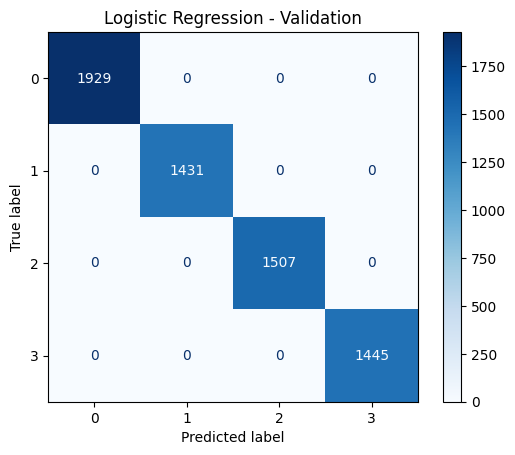

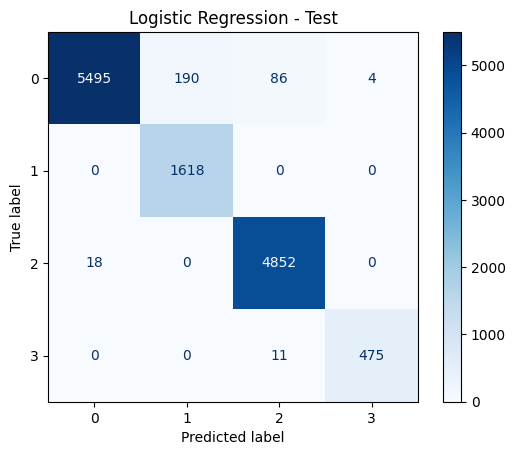

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from models import evaluate_model


def train_LR(train, test, labelTrain, labelTest):
    print(" Training Logistic Regression (optimized)...")

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train)
    X_train_scaled = scaler.transform(train)
    X_test_scaled = scaler.transform(test)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_scaled, labelTrain, test_size=0.2, random_state=42, stratify=labelTrain
    )

    lr = LogisticRegression(
        C=5,
        max_iter=10,
        penalty='l2',
        solver='newton-cg',
        random_state=21,
        multi_class='ovr'
    )

    lr.fit(X_train, y_train)
    evaluate_model(lr, X_train, y_train, X_val, y_val,
                   X_test_scaled, labelTest, "Logistic Regression")
    return lr, scaler


modelLR, scalerLr = train_LR(
    features_all, features_all_test, train_labels, train_labels_test)

In [29]:
def export_model_parameters(model, scaler):
    print("\n===== Model Parameters (for Arduino) =====")
    np.set_printoptions(suppress=True, precision=5, linewidth=200)

    # Weights
    print("\nconst float weights[NUM_CLASSES][NUM_FEATURES] = {")
    for class_weights in model.coef_:
        weight_str = ', '.join([f"{w: .5f}" for w in class_weights])
        print(f"  {{ {weight_str} }},")
    print("};")

    # Biases
    biases = ', '.join([f"{b: .5f}" for b in model.intercept_])
    print("\nconst float biases[NUM_CLASSES] = {")
    print(f"  {biases}")
    print("};")

    # Min values
    min_vals = ', '.join([f"{v: .5f}" for v in scaler.data_min_])
    print("\nconst float min_vals[NUM_FEATURES] = {")
    print(f"  {min_vals}")
    print("};")

    # Max values
    max_vals = ', '.join([f"{v: .5f}" for v in scaler.data_max_])
    print("\nconst float max_vals[NUM_FEATURES] = {")
    print(f"  {max_vals}")
    print("};")

    # Scale values
    scales = ', '.join([f"{v: .5f}" for v in scaler.scale_])
    print("\nconst float scale[NUM_FEATURES] = {")
    print(f"  {scales}")
    print("};")

In [30]:
import joblib

# Save model
joblib.dump(modelLR,  'onlyLR_minmax.dat')
joblib.dump(scalerLr, 'onlyScaler_minmax.dat')
print("[INFO] Model saved to onlyLR_minmax.dat and onlyScaler_minmax.dat")
export_model_parameters(modelLR, scalerLr)

[INFO] Model saved to onlyLR_minmax.dat and onlyScaler_minmax.dat

===== Model Parameters (for Arduino) =====

const float weights[NUM_CLASSES][NUM_FEATURES] = {
  {  4.44416,  4.86011,  0.45908, -13.68617,  0.92678, -0.92726,  0.71169,  6.67806, -5.75191,  0.55917,  2.97308, -0.55842,  7.95832,  2.36389, -2.20072 },
  {  1.79215,  1.57469,  7.53024,  8.17752,  2.60736, -2.60705,  6.25943, -5.98608,  1.47291, -1.38217, -0.39204,  1.37073, -1.52062, -2.36739, -1.12484 },
  {  1.91161,  1.83205, -6.80318,  8.12664, -0.52565,  0.51677, -6.64479, -2.37022,  2.73816,  0.91248, -0.14805, -0.91720, -5.70683, -1.67050,  5.24030 },
  { -4.71348, -4.73299,  0.57047, -6.29979, -1.46249,  1.45864,  0.61432,  5.71247, -1.98507, -1.06124,  0.51207,  1.05650,  0.84547,  0.29517,  0.93845 },
};

const float biases[NUM_CLASSES] = {
  -10.78234, -9.20160, -8.73283, -7.42629
};

const float min_vals[NUM_FEATURES] = {
  -1.00500, -1.00510, -1.02430,  0.00000,  0.00000,  0.00000, -1.02400,  0.00000,  0.783